In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy

In [2]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

mixed_precision.set_global_policy('mixed_float16')

True
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [3]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\test_data"

In [4]:
batch_size = 4

In [5]:
def train_gen(suj_path,mask_path):
    
    datagen = ImageDataGenerator(rescale=1./255)
    seed = 777
    
    image_train_generator = datagen.flow_from_directory(suj_path,class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=batch_size,seed=seed)
    mask_train_generator = datagen.flow_from_directory(mask_path,class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=batch_size,seed=seed)
    
    train_generator = zip(image_train_generator, mask_train_generator)

    for img,mask in train_generator:
        yield(img,mask)

In [6]:
train_gen_ds = train_gen(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = train_gen(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))


In [7]:
x,y = train_gen_ds.__next__()

Found 2720 images belonging to 1 classes.
Found 2720 images belonging to 1 classes.


In [8]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(4, 384, 384, 1)
(4, 384, 384, 1)
0.8588236 0.0
1.0 0.0


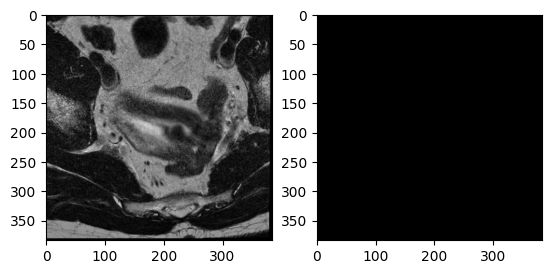

In [11]:
x,y = train_gen_ds.__next__()
for i in range(0,batch_size-1):
    image = x[i,:,:,0]
    mask = y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show

In [9]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos","img")))
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos","img")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

2720 1167


---


In [10]:
keras.backend.clear_session()

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [12]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation, dtype="float32")(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

In [13]:
def DiceBCE(targets, inputs, smooth=1e-3):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  binary_crossentropy(targets, inputs)
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-3)

In [21]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='/modelsh5/unet_model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [22]:
my_unet = build_unet(input_shape=(384,384,1), n_classes= 1)
#print(my_unet.summary())
my_unet.compile(optimizer = Adam(learning_rate = 1e-2), loss = DiceBCELoss, metrics = [DiceBCE])

In [18]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=50,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)

Epoch 1/50
680/680 [==============================] - 303s 446ms/step - loss: nan - DiceBCE: nan - val_loss: nan - val_DiceBCE: nan
Epoch 2/50
680/680 [==============================] - 299s 439ms/step - loss: nan - DiceBCE: nan - val_loss: nan - val_DiceBCE: nan
Epoch 3/50
314/680 [============>.................] - ETA: 2:26 - loss: nan - DiceBCE: nan

KeyboardInterrupt: 

In [19]:
history.history['dice_coef']

NameError: name 'history' is not defined

In [118]:
my_unet.save("test.hdf5")

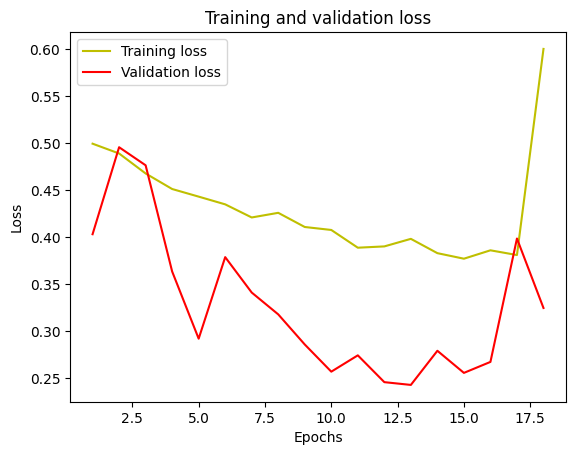

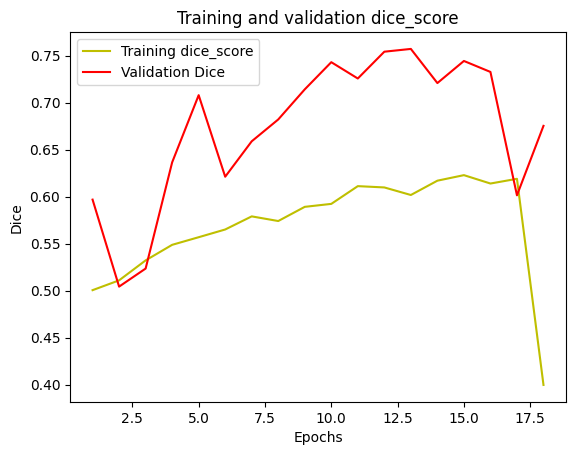

In [122]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step
Mean IoU = 0.4999288


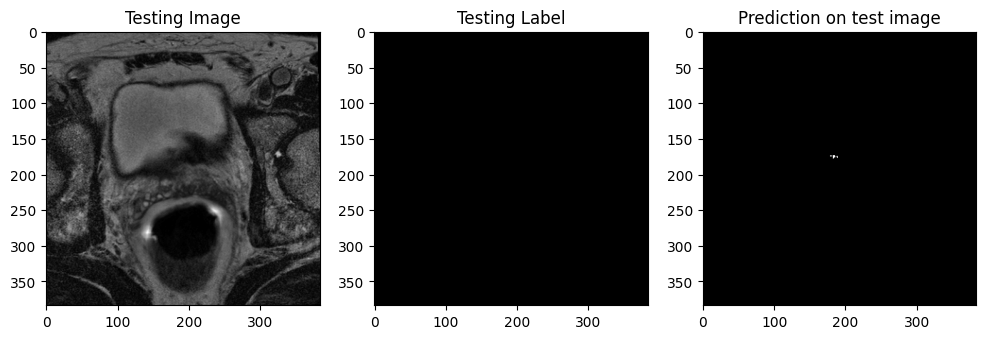

In [287]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()